In [1]:
import csv
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
import mediapipe as mp
from sklearn.metrics import confusion_matrix
import numpy as np


In [2]:
# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose

# Directory for TensorFlow.js model
tfjs_model_dir = 'model'


In [3]:
# Load CSV file
def load_csv(csv_path):
    df = pd.read_csv(csv_path)
    df.drop(df.columns[0], axis=1, inplace=True)  # Drop filename column
    class_names = df['class_name'].unique().tolist()
    df['class_no'] = df['class_name'].apply(lambda x: class_names.index(x))
    y = keras.utils.to_categorical(df.pop('class_no'))
    X = df.iloc[:, :-1].astype('float64')  # Exclude class_name column
    return X, y, class_names

In [4]:
# Load the CSV file
X, y, class_names = load_csv('train_data.csv')

# Combine X (features) and y (one-hot encoded labels) into a DataFrame for viewing
df_encoded = pd.DataFrame(X)
df_encoded['class'] = np.argmax(y, axis=1)  # Convert one-hot encoding back to class index for visibility

# Show the first five rows
print(df_encoded.head(400))


       NOSE_x    NOSE_y  NOSE_score  LEFT_EYE_INNER_x  LEFT_EYE_INNER_y  \
0    0.753882  0.551535    0.999950          0.767583          0.539537   
1    0.460116  0.844280    0.994730          0.481679          0.851948   
2    0.502046  0.696786    0.999924          0.516266          0.708586   
3    0.287299  0.405305    0.999898          0.278994          0.378392   
4    0.409069  0.510229    0.999957          0.396344          0.501537   
..        ...       ...         ...               ...               ...   
395  0.318253  0.573860    0.999093          0.310727          0.597987   
396  0.447584  0.696764    0.999852          0.425003          0.710601   
397  0.587068  0.327681    0.999045          0.608644          0.326884   
398  0.557217  0.299802    0.995131          0.584276          0.300876   
399  0.482250  0.664874    0.999349          0.471026          0.685458   

     LEFT_EYE_INNER_score  LEFT_EYE_x  LEFT_EYE_y  LEFT_EYE_score  \
0                0.999923    0

In [5]:
# Normalize pose landmarks
def normalize_pose_landmarks(landmarks):
    landmarks = tf.convert_to_tensor(landmarks, dtype=tf.float32)
    pose_center = (landmarks[mp_pose.PoseLandmark.LEFT_HIP.value][:2] +
                   landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value][:2]) / 2
    landmarks = landmarks[:, :2] - pose_center  # Normalize to hip center
    pose_size = tf.reduce_max(tf.norm(landmarks, axis=1))
    landmarks /= pose_size  # Scale landmarks
    return landmarks

In [6]:
# Convert landmarks to embeddings
def landmarks_to_embedding(landmarks):
    normalized_landmarks = normalize_pose_landmarks(landmarks)
    embedding = tf.reshape(normalized_landmarks, [-1])  # Flatten to 66 values
    return embedding

In [7]:
# Preprocess dataset
def preprocess_data(X_data):
    processed_X = []
    for i in range(X_data.shape[0]):
        embedding = landmarks_to_embedding(X_data.iloc[i].values.reshape(33, 3))  # Ensure 33 landmarks
        processed_X.append(embedding)
    return tf.convert_to_tensor(processed_X)


In [8]:
import tensorflow.keras as keras

print(tf.__version__)
print(tf.keras.__version__)



2.18.0
3.8.0.dev2025021303


In [9]:
# Load and process data
X, y, class_names = load_csv('train_data.csv')
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)
X_test, y_test, _ = load_csv('test_data.csv')

processed_X_train = preprocess_data(X_train)
processed_X_val = preprocess_data(X_val)
processed_X_test = preprocess_data(X_test)

In [10]:
# Build Model
inputs = tf.keras.Input(shape=(66,))  # 33 landmarks * 2 (x, y normalized)
layer = keras.layers.Dense(256, activation='relu')(inputs)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(128, activation='relu')(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation='softmax')(layer)

model = keras.Model(inputs, outputs)


In [11]:
# Compile Model
optimizer = keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint_path = "weights.best.keras"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                                             monitor='val_accuracy',
                                             verbose=1,
                                             save_best_only=True,
                                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=40)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                              factor=0.5,
                                              patience=5,
                                              min_lr=1e-6)

In [12]:
# Train Model
print('--------------TRAINING----------------')
history = model.fit(processed_X_train, y_train,
                    epochs=250,
                    batch_size=16,
                    validation_data=(processed_X_val, y_val),
                    callbacks=[checkpoint, earlystopping])


--------------TRAINING----------------
Epoch 1/250
218/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2004 - loss: 1.9302
Epoch 1: val_accuracy improved from -inf to 0.56108, saving model to weights.best.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2100 - loss: 1.9153 - val_accuracy: 0.5611 - val_loss: 1.4586
Epoch 2/250
237/250 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - accuracy: 0.4335 - loss: 1.5003
Epoch 2: val_accuracy improved from 0.56108 to 0.68750, saving model to weights.best.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4354 - loss: 1.4953 - val_accuracy: 0.6875 - val_loss: 1.0838
Epoch 3/250
216/250 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - accuracy: 0.5569 - loss: 1.2020
Epoch 3: val_accuracy improved from 0.68750 to 0.72727, saving model to weights.best.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5583 - loss: 1.1959 - val_accuracy: 0.7273 - val_loss: 0.9234
Epoch 4/250
233/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6206 - l

In [13]:
# Get true labels (convert one-hot encoding to class indices)
y_true_classes = np.argmax(y_test, axis=1)

# Get predicted labels
y_pred = model.predict(processed_X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


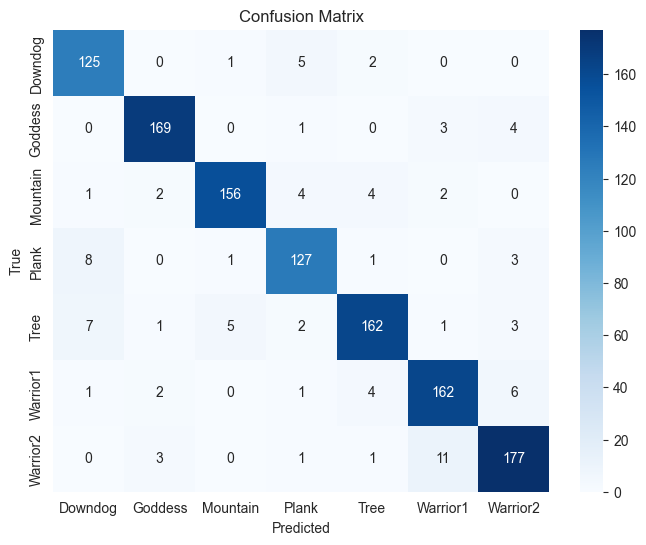

In [14]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [15]:
from sklearn.metrics import classification_report

# Classification Report
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

              precision    recall  f1-score   support

     Downdog       0.88      0.94      0.91       133
     Goddess       0.95      0.95      0.95       177
    Mountain       0.96      0.92      0.94       169
       Plank       0.90      0.91      0.90       140
        Tree       0.93      0.90      0.91       181
    Warrior1       0.91      0.92      0.91       176
    Warrior2       0.92      0.92      0.92       193

    accuracy                           0.92      1169
   macro avg       0.92      0.92      0.92      1169
weighted avg       0.92      0.92      0.92      1169



In [16]:
# Evaluate Model
print('-----------------EVALUATION----------------')
loss, accuracy = model.evaluate(processed_X_test, y_test)
print('LOSS:', loss)
print('ACCURACY:', accuracy)

# Save Model for TensorFlow.js
#tfjs.converters.save_keras_model(model, tfjs_model_dir)
#print('tfjs model saved at', tfjs_model_dir)


-----------------EVALUATION----------------
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9345 - loss: 0.3710 
LOSS: 0.4301410913467407
ACCURACY: 0.9221556782722473


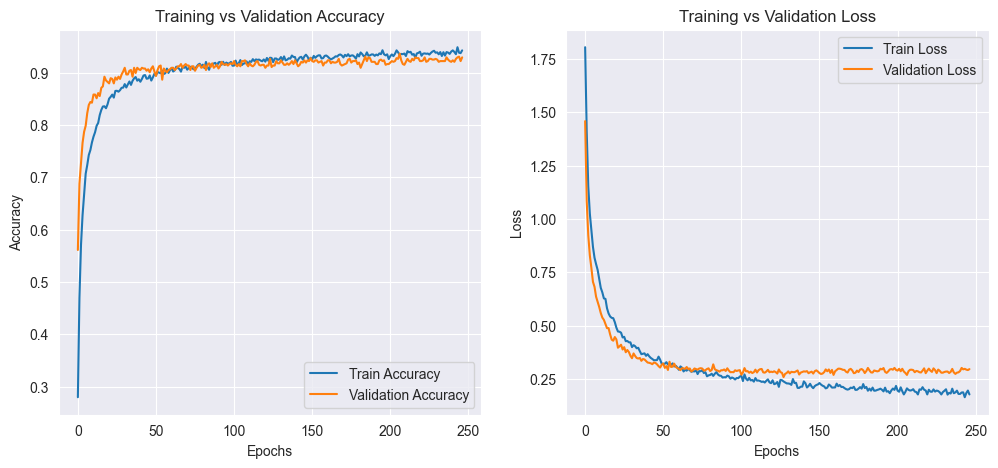

In [17]:
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')

plt.show()


In [18]:

##Save and Load Best Model

##Modify checkpoint saving
#best_model_path = "best_model.keras"
#model.save(best_model_path)

##Then, load it later
#from tensorflow.keras.models import load_model
#loaded_model = load_model(best_model_path)

